# Introduction:                                                                                                        

 Hi! The purpose of this notebook is to, using particular given census data, determine which factors play the biggest role as to whether an individual makes over or under 50K annually and to develop a predictive classifier to determine whether a random individual would make over or under 50K annually. Our dataset comprises of both categorical and numerical data ranging from living to economic attributes. 



##### Intuitvely, I initially thought that the factors most related to whether an individual would make 50K would most likely be factors having to do with age, education, and occupation information. In my experience, the older an individual is, the more money he/she makes, and today's market salaries are pretty heavily dependent on the role and industry one is currently in. I'll be keeping a close eye out to specifically the age, education, and industry of each individual.

##### Conclusively, I found that while these factors are the most correlated with whether an individual makes 50K, it is difficult to accurately determine whether an individual actually makes 50K; our model resulted in a high proportion of false positives. While feature selection did show clear correlation, without further info, it's hard to say whether these factors are the "determinant" or just correlated. With more time, I believe a more thorough data cleaning would most likely rid us of false positives  (along with some model tweaking!).

In [1]:
##formats markdown cells
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;

}
div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}
div.text_cell_render { /* Customize text cells */
font-family: 'Calibri';
font-size:1.5em;
line-height:1.4em;
padding-right:3em;
}
</style>
""")

In [2]:
#imports necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

Firstly, I noticed that the data in the Excel file lacked column names, so I went ahead and added a list of column names in order with what they appear as (I followed the .txt file order, only adding in instance weight for one of the numerical columns). I ultimately took the instance weight column out as in the text file, it said that this attribute should be ignored.

In [3]:
#manually created list of column names
col_names = ["age", "class of worker", "detailed industry recode", "detailed occupation recode", "education", "wage per hour", "enroll in edu inst last wk", "marital stat", "major industry code", "major occupation code", "race", "hispanic origin", "sex", "member of a labor union", "reason for unemployment", "full or part time employment stat", "capital gains", "capital losses", "dividends from stocks", "tax filer stat", "region of previous residence", "state of previous residence", "detailed household and family stat", "detailed household summary in household", "instance weight", "migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "live in this house 1 year ago", "migration prev res in sunbelt", "num persons worked for employer", "family members under 18", "country of birth father", "country of birth mother", "country of birth self", "citizenship", "own business or self employed", "fill inc questionnaire for veteran's admin", "veterans benefits", "weeks worked in year", "year", "50000"]

In [4]:
## loads csv, drops column instance weight
df = pd.read_csv("/Users/David Sung/Desktop/us_census_fuLl/census_income_learn.csv", names = col_names, header= None)
df = df.drop(['instance weight'], axis=1)
col_names = list(df.columns)
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,50000
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


As we can see below, our DataFrame has 199523 entries, with 199523 non-null objects. Pretty clean data at a high-level, we won't have to drop nulls, but we'll have to verify whether our data is a good representation of the entire population.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
age                                           199523 non-null int64
class of worker                               199523 non-null object
detailed industry recode                      199523 non-null int64
detailed occupation recode                    199523 non-null int64
education                                     199523 non-null object
wage per hour                                 199523 non-null int64
enroll in edu inst last wk                    199523 non-null object
marital stat                                  199523 non-null object
major industry code                           199523 non-null object
major occupation code                         199523 non-null object
race                                          199523 non-null object
hispanic origin                               199523 non-null object
sex                                           199523 non-null obj

#### First Impressions

Running descriptive statistics, I noticed that many of these stats have very high standard deviations in relation to the mean, implying a wide range of different values or perhaps even some numerical outliers.

Specifically, in the "age" column, having a mean of 34.5 and a STD of 22.3 stuck out to me; the fact that there's this high a range in age values could imply skewness due to data including too many extremes (such as 25% of the population between under the age of 15, or another 25% being over 50).

For wage per hour/capital gains/losses/dividends from stocks, I noticed that this data most likely contains outliers as their max values seem very incorrect given the nature of the data (do people really make $10K/an hour?). Once again, I think this could easily account for the extremely high mean and STD for said columns. Wasn't sure whether I'd want to include this in my data since, at a glance, it seems like the value's seem pretty inaccurate.

All in all, if our hypothesis is correct, then much of our data should be skewed towards a younger audience, as well as, once outliers removed, people that ultimately make less money, thereby having less people that make 50K. Let's see whether this is true!


In [6]:
df.describe()

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


I wanted to make sure the '50000' column had more workable objects to test for correlation, so I decided to actually make another column that would be more easily worked with (where 1 would signify over 50k and 0 being under 50k)

In [7]:
df['50000'].dtypes

dtype('O')

In [8]:
## adds an extra column into dataframe where a 1 signifies over $50k, and 0 signifies under $50K
df['50000yesno'] = np.where(df['50000'] == ' 50000+.', int(1), int(0))

#### Does the dataset have a proper, equal distribution of individuals who make under/over 50K?

As my initial thought process was that much of the dataset would be weighted towards people that do not make 50K (noticed above with the distribution of hours worked and the wage per hour columns), I wanted to double-check the distribution of the 50000 column to verify this claim. As seen below, it's clear that only roughly 6% made above $50K/yr.

Thus, I wanted an close to 1:1 distribution of under 50k to over 50k to better see proportions of each data (if most of my data is one-sided, it'll be hard to determine a holistic view of stats). So let's even out our datasets! With this, I decided to oversample and up my >50K sample.

I made the assumption that the data collected is representative of the entire population; I'm going to look to duplicate the individuals over $50K data until the number of individuals over 50K close to even with the number of  individuals under 50K, a strategy known as oversampling.

Something to note though: it is very possible that oversampling could result in false positives/overfit our data since we're making duplicates.

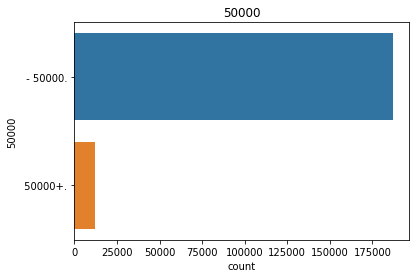

 - 50000.    187141
 50000+.      12382
Name: 50000, dtype: int64

In [9]:
#plots my original 50k data to see the distribution that we're currently working with
c_palette = ['tab:blue', 'tab:orange']
ax = sns.countplot(y="50000", data=df, palette=c_palette)
ax.set_title('50000')
plt.show()
df['50000'].value_counts()

In [10]:
## double checking that my value_counts in my newly created column is the same as the 50000 column
df['50000yesno'].value_counts()
## creates an extra dataframe that only includes individuals who made over $50K
dfjust50000=df[df['50000yesno'] == 1]

In [11]:
print (187141/12382)
## adds our dataframe containing only individuals >50K to our original data frame 14 times to even our proportions.
df_final = df
for i in range(0,14):
    df_final = pd.concat([df_final, dfjust50000])
## verifies that the 50000yesno column has almost equal numbers of yes and no's.
df_final['50000yesno'].value_counts()

15.113955742206429


0    187141
1    185730
Name: 50000yesno, dtype: int64

#### Disclaimer: a 0 represents an individual making less than 50K annually, and a 1 represents an individual who makes greater than or equal to 50K annually.

#### Visualizing the data

Time for some analysis and visualization! Our data seems to be mostly set, let's look at the proportions of each attribute individually to see if we can find any support for our hypothesis that age, education, and occupation/industry code will most directly impact whether an individual makes >50K annually. We believe that as age and education level increases, so will the likelihood one makes >50K annually, and that there should be certain industries where there is a higher proportion of people making >50K.

We'll be going through each attribute's distribution to determine which are the most relevant to a person's annual salary, and this could also include other attributes not already mentioned in our hypothesis.

In [12]:
## function, with two dataframe inputs, that displays a countplot of a specific column seen in both inputs.
def categorical_summarized(dataframe, dataframe2, x=None, y=None, hue=None, palette='Set1', verbose=True):
    ## determines which axis the variable will be on
    if x == None:
        column_interested = y
    else:
        column_interested = x
    ## creates univariate statistics of aforementioned column using .describe, .mode, and .value_counts()
    series = dataframe[column_interested]
    df2 = dataframe
    print(series.describe())
    print('mode: ', series.mode())
    ## same as above, but finds statistics for the second dataframe input.
    series2 = dataframe2[column_interested]
    df3 = dataframe2
    print(series2.describe())
    print('mode: ', series2.mode())
    ## created an if statement for value_counts in case one doesn't need it, grouped by the "hue" input.
    if verbose:
        print('='*80)
        print(df2.groupby(hue)[column_interested].value_counts())
        print('='*80)
        print(df3.groupby(hue)[column_interested].value_counts())
    ## displays two plots, data is grouped by the "hue" column, and each plot plots for each respective dataframe input.
    fig, ax =plt.subplots(1,2, figsize=(10,5))
    ax1 = sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax =ax[0])
    ax2 = sns.countplot(x=x, y=y, hue=hue, data=dataframe2, palette=palette, ax =ax[1])
    ax1.set_title(column_interested)
    ax2.set_title(column_interested)
    plt.show()

Below are the before and after graphs for each attribute (column) within the dataset. In order to solidify a more supported hypothesis, I decided to check each graph individually to find any trends that I might come across. Graphs that showed very obvious trends I then decided to further analyze to see if I could support my intuition!

In [13]:
df_final.drop('50000',axis=1)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,50000yesno
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
5,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,0
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
7,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,0
8,47,Local government,43,26,Some college but no degree,876,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,0
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0


count    199523.000000
mean         34.494199
std          22.310895
min           0.000000
25%          15.000000
50%          33.000000
75%          50.000000
max          90.000000
Name: age, dtype: float64
mode:  0    34
dtype: int64
count    372871.000000
mean         39.967007
std          19.128527
min           0.000000
25%          29.000000
50%          41.000000
75%          52.000000
max          90.000000
Name: age, dtype: float64
mode:  0    46
dtype: int64


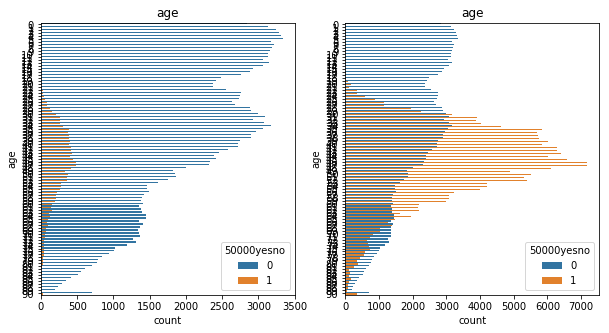

count               199523
unique                   9
top        Not in universe
freq                100245
Name: class of worker, dtype: object
mode:  0     Not in universe
dtype: object
count       372871
unique           9
top        Private
freq        174536
Name: class of worker, dtype: object
mode:  0     Private
dtype: object


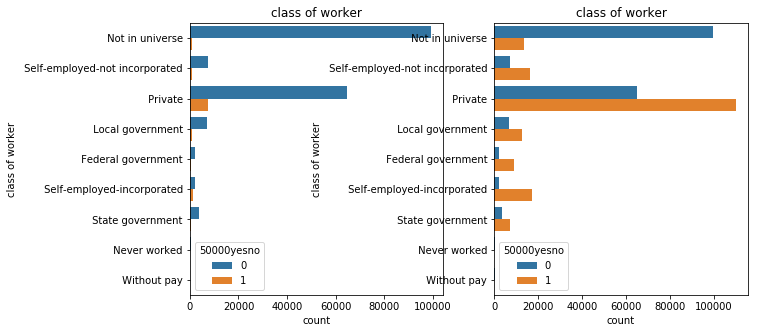

count    199523.000000
mean         15.352320
std          18.067129
min           0.000000
25%           0.000000
50%           0.000000
75%          33.000000
max          51.000000
Name: detailed industry recode, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean         21.758713
std          18.171354
min           0.000000
25%           0.000000
50%          29.000000
75%          38.000000
max          51.000000
Name: detailed industry recode, dtype: float64
mode:  0    0
dtype: int64


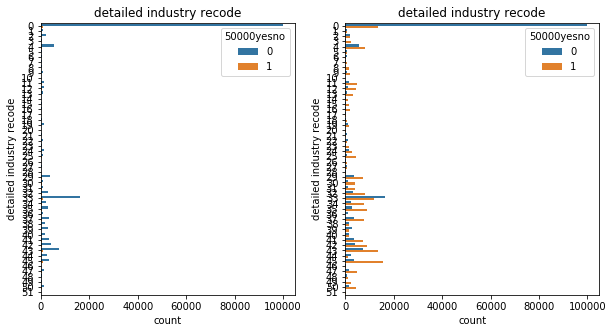

count    199523.000000
mean         11.306556
std          14.454204
min           0.000000
25%           0.000000
50%           0.000000
75%          26.000000
max          46.000000
Name: detailed occupation recode, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean         11.656986
std          13.397643
min           0.000000
25%           0.000000
50%           4.000000
75%          19.000000
max          46.000000
Name: detailed occupation recode, dtype: float64
mode:  0    0
dtype: int64


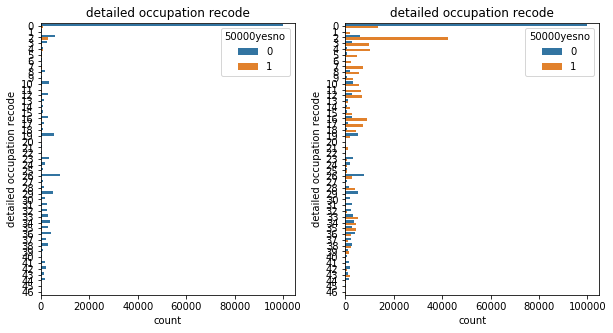

count                    199523
unique                       17
top        High school graduate
freq                      48407
Name: education, dtype: object
mode:  0     High school graduate
dtype: object
count                    372871
unique                       17
top        High school graduate
freq                      74713
Name: education, dtype: object
mode:  0     High school graduate
dtype: object


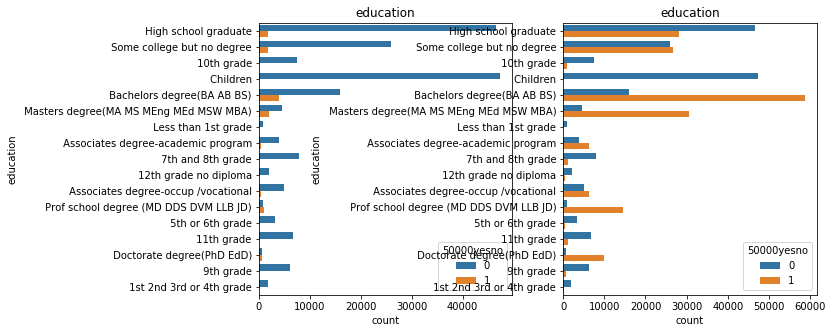

count    199523.000000
mean         55.426908
std         274.896454
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        9999.000000
Name: wage per hour, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean         67.613526
std         356.520927
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        9999.000000
Name: wage per hour, dtype: float64
mode:  0    0
dtype: int64


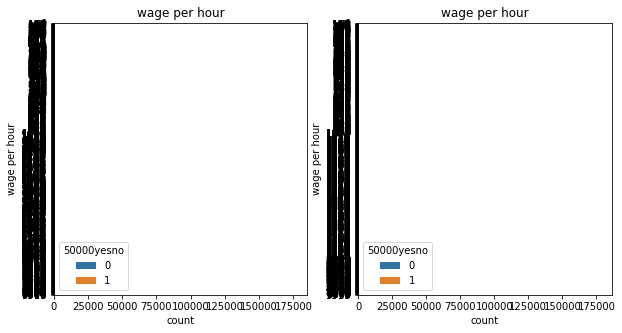

count               199523
unique                   3
top        Not in universe
freq                186943
Name: enroll in edu inst last wk, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                   3
top        Not in universe
freq                359871
Name: enroll in edu inst last wk, dtype: object
mode:  0     Not in universe
dtype: object


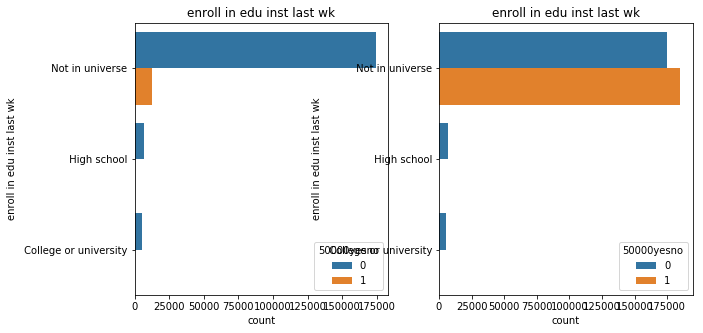

count             199523
unique                 7
top        Never married
freq               86485
Name: marital stat, dtype: object
mode:  0     Never married
dtype: object
count                               372871
unique                                   7
top        Married-civilian spouse present
freq                                218622
Name: marital stat, dtype: object
mode:  0     Married-civilian spouse present
dtype: object


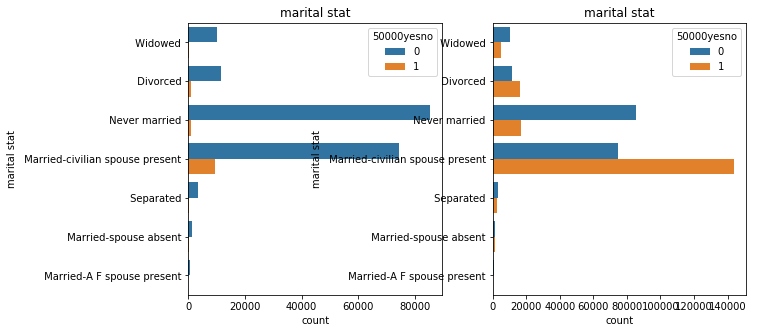

count                           199523
unique                              24
top        Not in universe or children
freq                            100684
Name: major industry code, dtype: object
mode:  0     Not in universe or children
dtype: object
count                           372871
unique                              24
top        Not in universe or children
freq                            113368
Name: major industry code, dtype: object
mode:  0     Not in universe or children
dtype: object


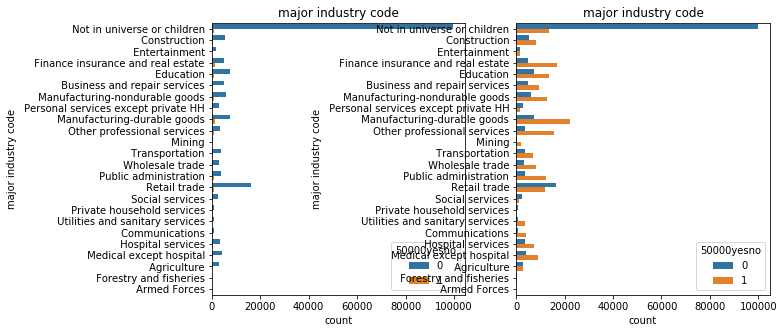

count               199523
unique                  15
top        Not in universe
freq                100684
Name: major occupation code, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                  15
top        Not in universe
freq                113368
Name: major occupation code, dtype: object
mode:  0     Not in universe
dtype: object


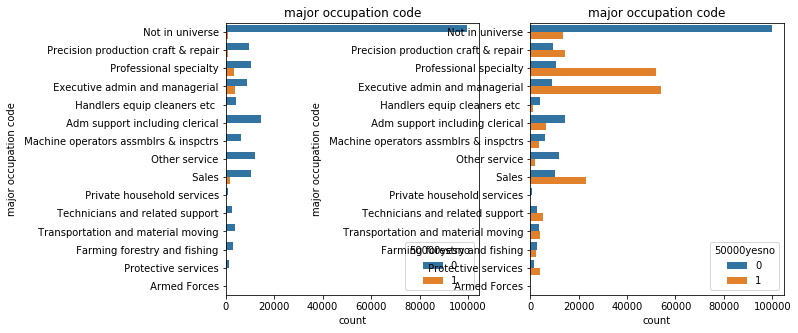

count     199523
unique         5
top        White
freq      167365
Name: race, dtype: object
mode:  0     White
dtype: object
count     372871
unique         5
top        White
freq      325173
Name: race, dtype: object
mode:  0     White
dtype: object


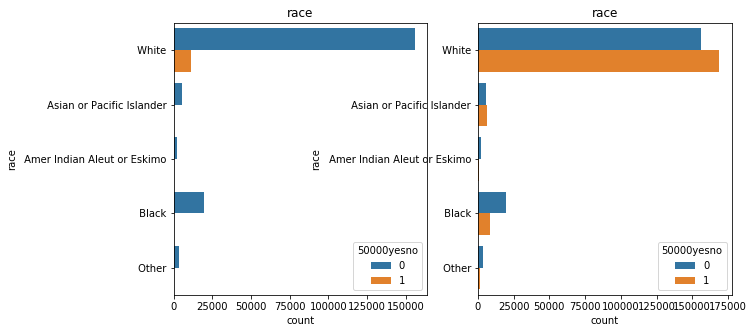

count         199523
unique            10
top        All other
freq          171907
Name: hispanic origin, dtype: object
mode:  0     All other
dtype: object
count         372871
unique            10
top        All other
freq          336645
Name: hispanic origin, dtype: object
mode:  0     All other
dtype: object


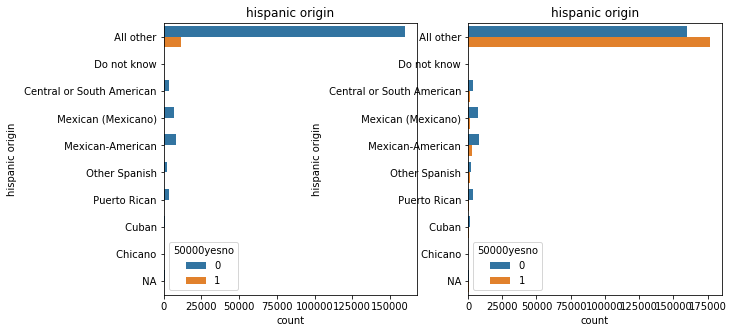

count      199523
unique          2
top        Female
freq       103984
Name: sex, dtype: object
mode:  0     Female
dtype: object
count     372871
unique         2
top         Male
freq      231605
Name: sex, dtype: object
mode:  0     Male
dtype: object


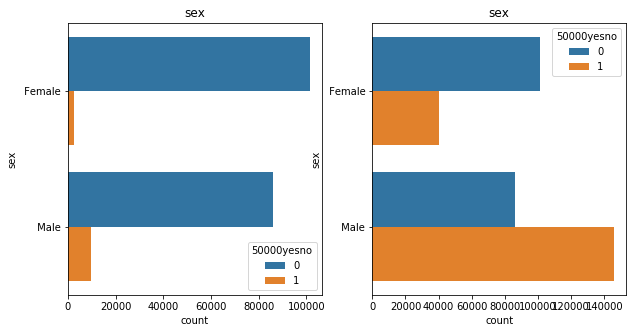

count               199523
unique                   3
top        Not in universe
freq                180459
Name: member of a labor union, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                   3
top        Not in universe
freq                322531
Name: member of a labor union, dtype: object
mode:  0     Not in universe
dtype: object


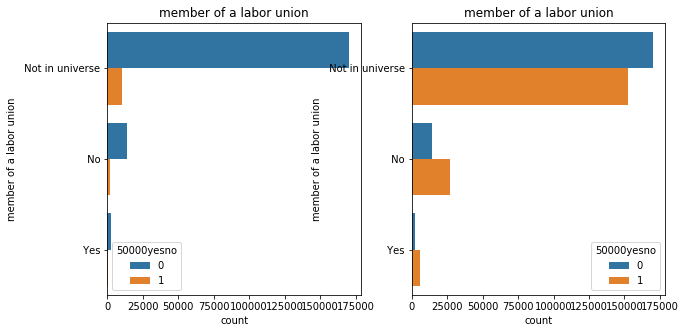

count               199523
unique                   6
top        Not in universe
freq                193453
Name: reason for unemployment, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                   6
top        Not in universe
freq                364421
Name: reason for unemployment, dtype: object
mode:  0     Not in universe
dtype: object


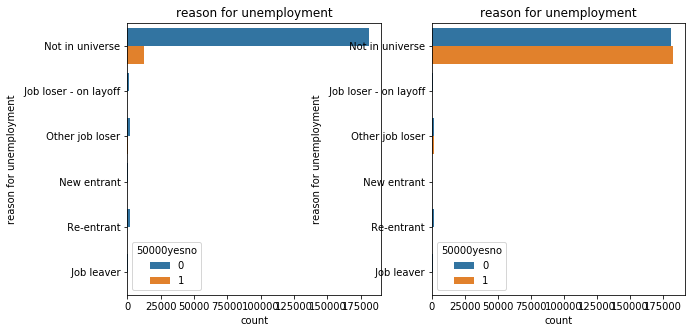

count                        199523
unique                            8
top        Children or Armed Forces
freq                         123769
Name: full or part time employment stat, dtype: object
mode:  0     Children or Armed Forces
dtype: object
count                        372871
unique                            8
top        Children or Armed Forces
freq                         206005
Name: full or part time employment stat, dtype: object
mode:  0     Children or Armed Forces
dtype: object


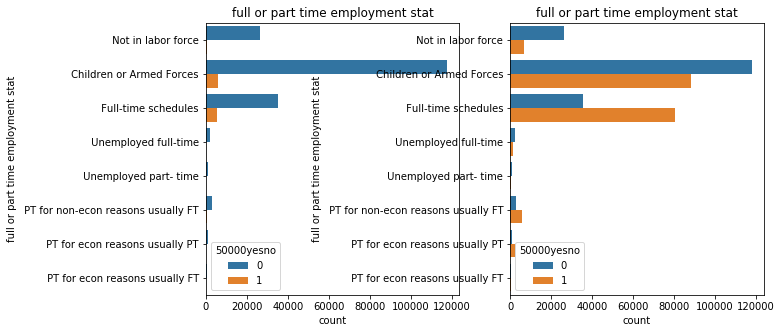

count    199523.00000
mean        434.71899
std        4697.53128
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       99999.00000
Name: capital gains, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean       2478.520724
std       12214.391659
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       99999.000000
Name: capital gains, dtype: float64
mode:  0    0
dtype: int64


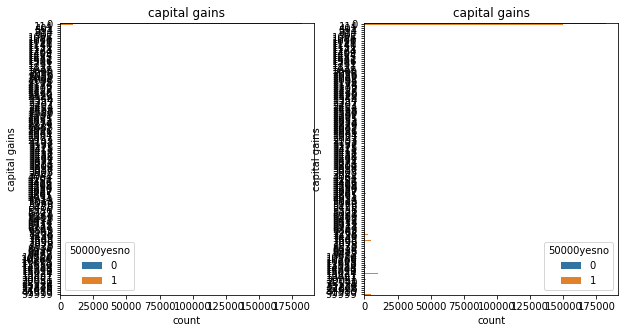

count    199523.000000
mean         37.313788
std         271.896428
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4608.000000
Name: capital losses, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean        109.757302
std         466.030258
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4608.000000
Name: capital losses, dtype: float64
mode:  0    0
dtype: int64


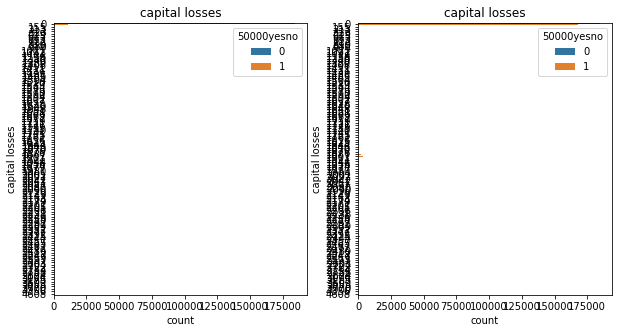

count    199523.000000
mean        197.529533
std        1984.163658
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       99999.000000
Name: dividends from stocks, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean        827.897050
std        5032.872436
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max       99999.000000
Name: dividends from stocks, dtype: float64
mode:  0    0
dtype: int64


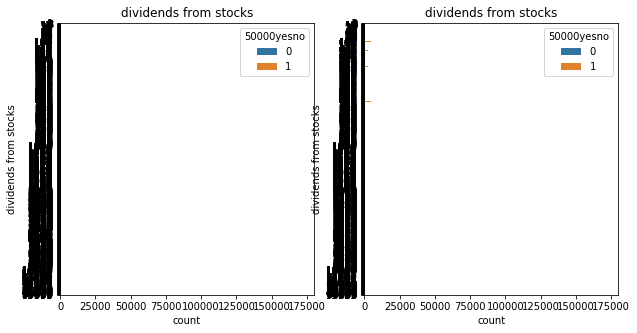

count        199523
unique            6
top        Nonfiler
freq          75094
Name: tax filer stat, dtype: object
mode:  0     Nonfiler
dtype: object
count                   372871
unique                       6
top        Joint both under 65
freq                    191325
Name: tax filer stat, dtype: object
mode:  0     Joint both under 65
dtype: object


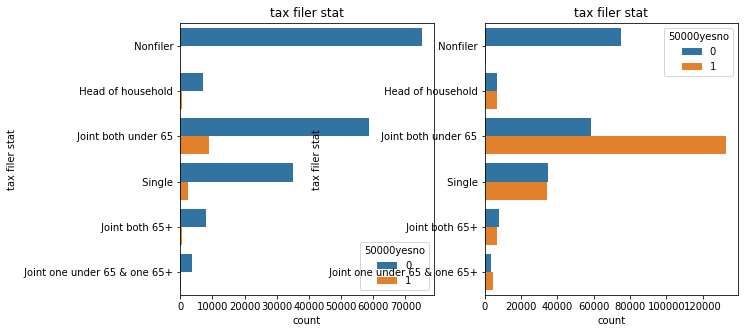

count               199523
unique                   6
top        Not in universe
freq                183750
Name: region of previous residence, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                   6
top        Not in universe
freq                348446
Name: region of previous residence, dtype: object
mode:  0     Not in universe
dtype: object


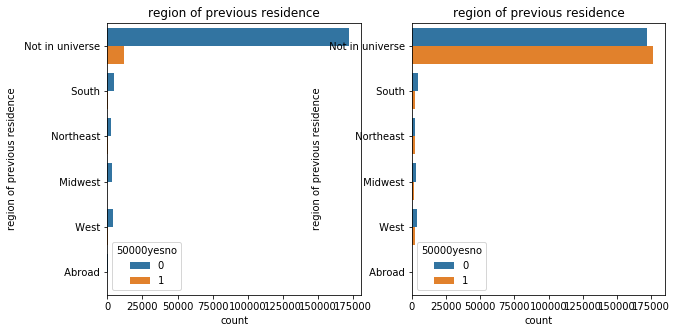

count               199523
unique                  51
top        Not in universe
freq                183750
Name: state of previous residence, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                  51
top        Not in universe
freq                348446
Name: state of previous residence, dtype: object
mode:  0     Not in universe
dtype: object


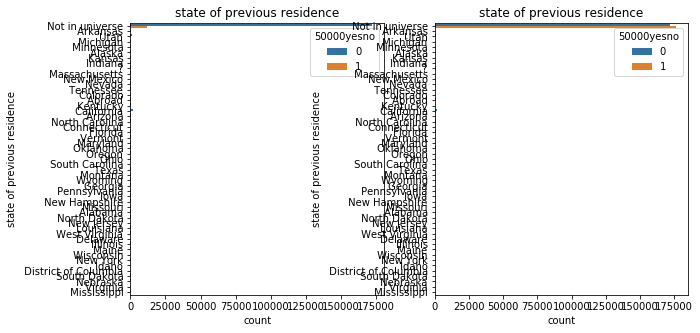

count           199523
unique              38
top        Householder
freq             53248
Name: detailed household and family stat, dtype: object
mode:  0     Householder
dtype: object
count           372871
unique              38
top        Householder
freq            163148
Name: detailed household and family stat, dtype: object
mode:  0     Householder
dtype: object


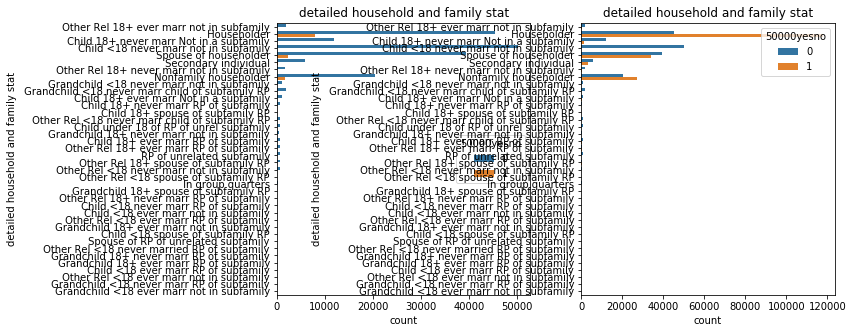

count           199523
unique               8
top        Householder
freq             75475
Name: detailed household summary in household, dtype: object
mode:  0     Householder
dtype: object
count           372871
unique               8
top        Householder
freq            210589
Name: detailed household summary in household, dtype: object
mode:  0     Householder
dtype: object


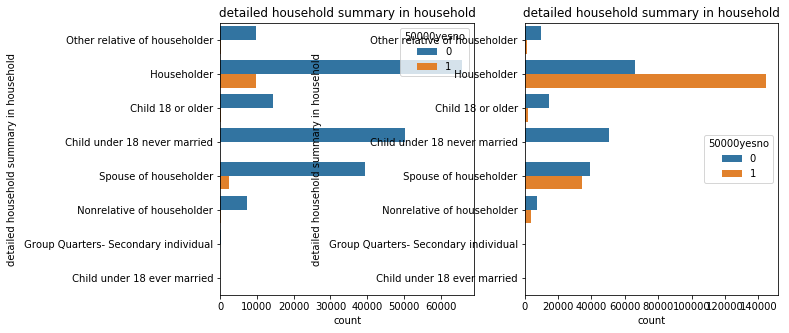

count     199523
unique        10
top            ?
freq       99696
Name: migration code-change in msa, dtype: object
mode:  0     ?
dtype: object
count     372871
unique        10
top            ?
freq      191298
Name: migration code-change in msa, dtype: object
mode:  0     ?
dtype: object


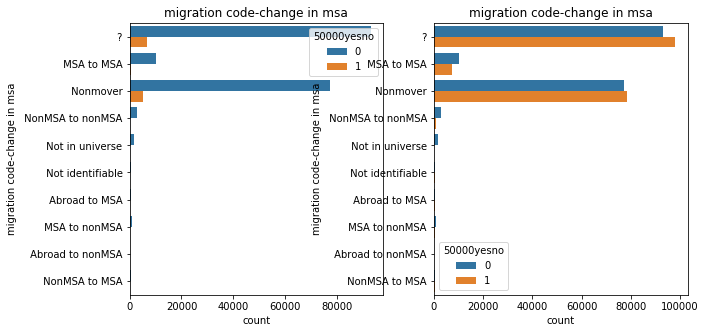

count     199523
unique         9
top            ?
freq       99696
Name: migration code-change in reg, dtype: object
mode:  0     ?
dtype: object
count     372871
unique         9
top            ?
freq      191298
Name: migration code-change in reg, dtype: object
mode:  0     ?
dtype: object


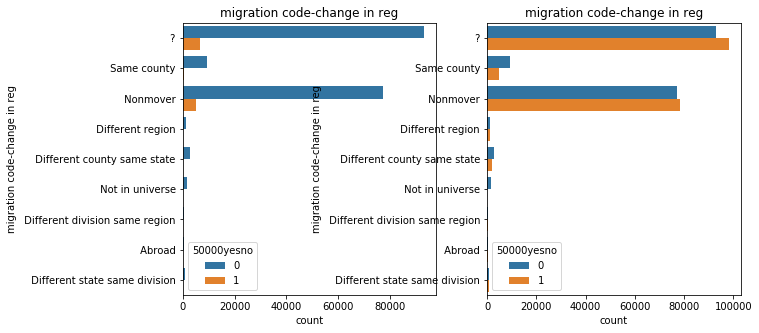

count     199523
unique        10
top            ?
freq       99696
Name: migration code-move within reg, dtype: object
mode:  0     ?
dtype: object
count     372871
unique        10
top            ?
freq      191298
Name: migration code-move within reg, dtype: object
mode:  0     ?
dtype: object


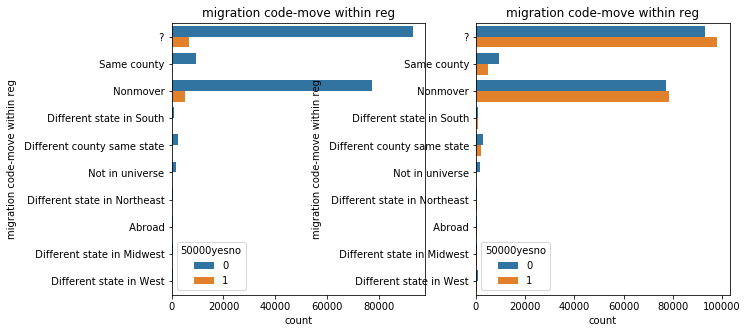

count                                199523
unique                                    3
top        Not in universe under 1 year old
freq                                 101212
Name: live in this house 1 year ago, dtype: object
mode:  0     Not in universe under 1 year old
dtype: object
count                                372871
unique                                    3
top        Not in universe under 1 year old
freq                                 192814
Name: live in this house 1 year ago, dtype: object
mode:  0     Not in universe under 1 year old
dtype: object


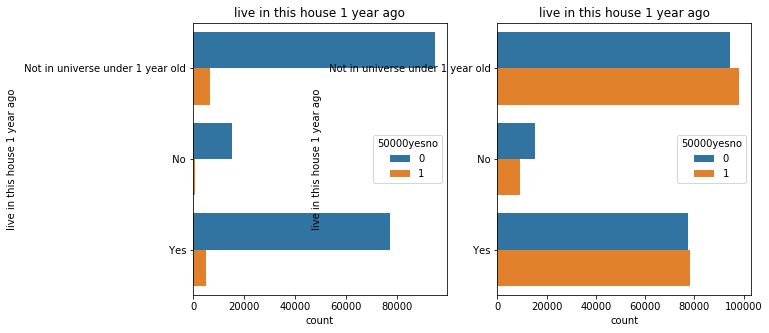

count     199523
unique         4
top            ?
freq       99696
Name: migration prev res in sunbelt, dtype: object
mode:  0     ?
dtype: object
count     372871
unique         4
top            ?
freq      191298
Name: migration prev res in sunbelt, dtype: object
mode:  0     ?
dtype: object


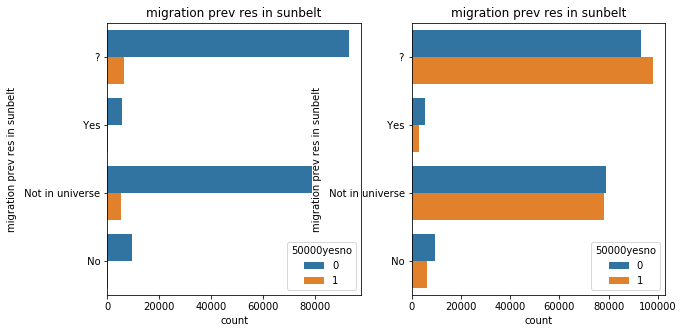

count    199523.000000
mean          1.956180
std           2.365126
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max           6.000000
Name: num persons worked for employer, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean          2.908081
std           2.474244
min           0.000000
25%           0.000000
50%           3.000000
75%           6.000000
max           6.000000
Name: num persons worked for employer, dtype: float64
mode:  0    6
dtype: int64


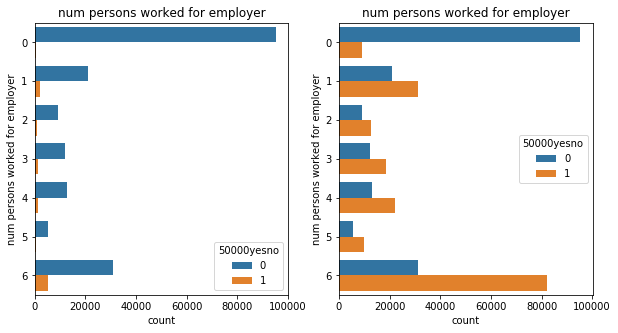

count               199523
unique                   5
top        Not in universe
freq                144232
Name: family members under 18, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                   5
top        Not in universe
freq                317552
Name: family members under 18, dtype: object
mode:  0     Not in universe
dtype: object


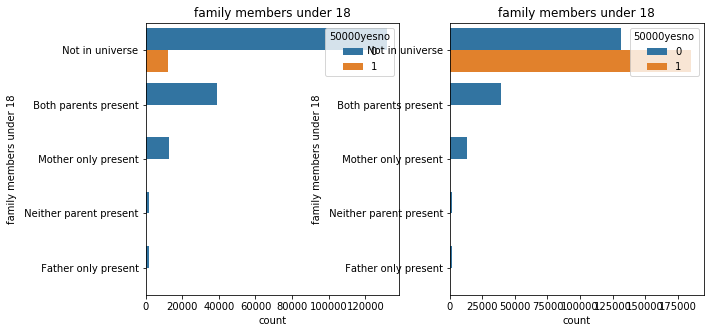

count             199523
unique                43
top        United-States
freq              159163
Name: country of birth father, dtype: object
mode:  0     United-States
dtype: object
count             372871
unique                43
top        United-States
freq              303391
Name: country of birth father, dtype: object
mode:  0     United-States
dtype: object


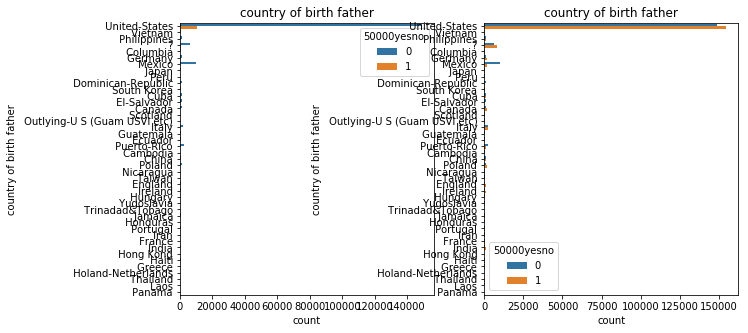

count             199523
unique                43
top        United-States
freq              160479
Name: country of birth mother, dtype: object
mode:  0     United-States
dtype: object
count             372871
unique                43
top        United-States
freq              305911
Name: country of birth mother, dtype: object
mode:  0     United-States
dtype: object


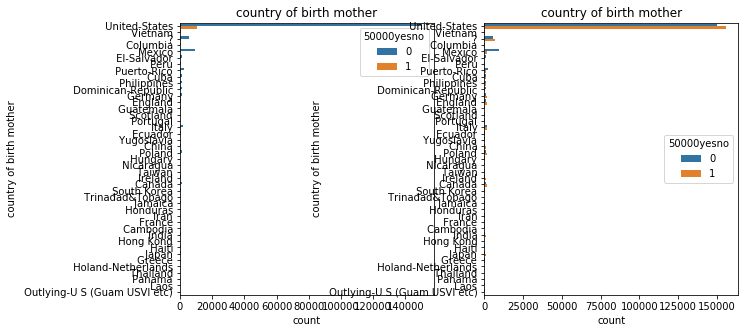

count             199523
unique                43
top        United-States
freq              176989
Name: country of birth self, dtype: object
mode:  0     United-States
dtype: object
count             372871
unique                43
top        United-States
freq              333075
Name: country of birth self, dtype: object
mode:  0     United-States
dtype: object


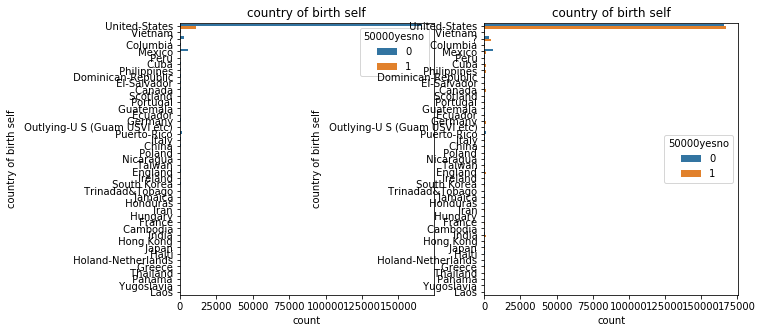

count                                 199523
unique                                     5
top        Native- Born in the United States
freq                                  176992
Name: citizenship, dtype: object
mode:  0     Native- Born in the United States
dtype: object
count                                 372871
unique                                     5
top        Native- Born in the United States
freq                                  333078
Name: citizenship, dtype: object
mode:  0     Native- Born in the United States
dtype: object


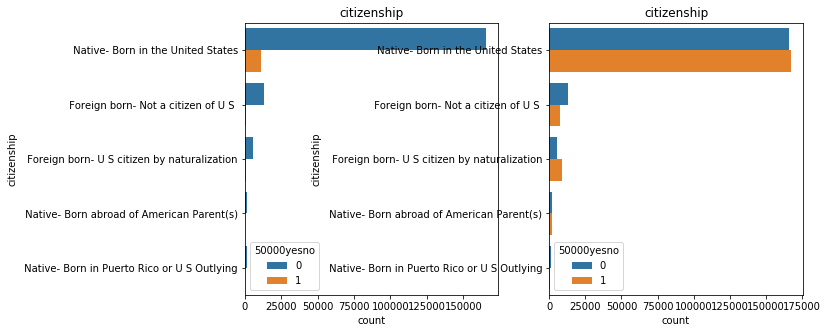

count    199523.000000
mean          0.175438
std           0.553694
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: own business or self employed, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean          0.215941
std           0.595945
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: own business or self employed, dtype: float64
mode:  0    0
dtype: int64


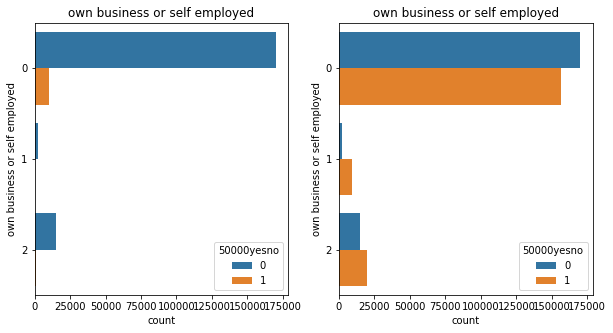

count               199523
unique                   3
top        Not in universe
freq                197539
Name: fill inc questionnaire for veteran's admin, dtype: object
mode:  0     Not in universe
dtype: object
count               372871
unique                   3
top        Not in universe
freq                367653
Name: fill inc questionnaire for veteran's admin, dtype: object
mode:  0     Not in universe
dtype: object


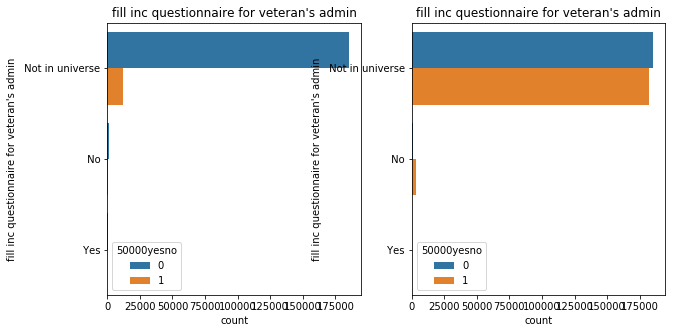

count    199523.000000
mean          1.514833
std           0.851473
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: veterans benefits, dtype: float64
mode:  0    2
dtype: int64
count    372871.000000
mean          1.731714
std           0.671269
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: veterans benefits, dtype: float64
mode:  0    2
dtype: int64


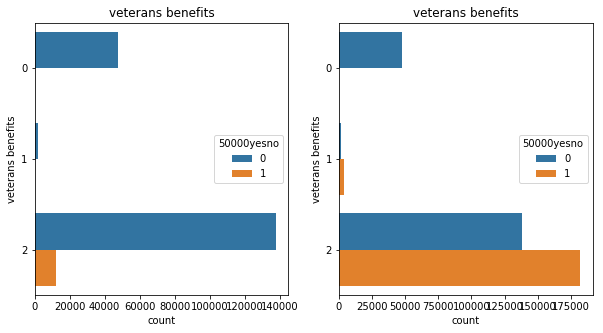

count    199523.000000
mean         23.174897
std          24.411488
min           0.000000
25%           0.000000
50%           8.000000
75%          52.000000
max          52.000000
Name: weeks worked in year, dtype: float64
mode:  0    0
dtype: int64
count    372871.000000
mean         34.748471
std          23.300551
min           0.000000
25%           0.000000
50%          52.000000
75%          52.000000
max          52.000000
Name: weeks worked in year, dtype: float64
mode:  0    52
dtype: int64


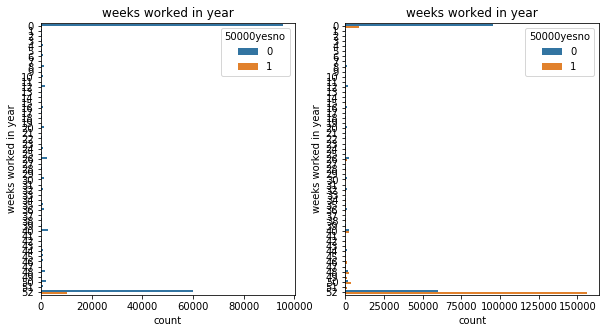

count    199523.000000
mean         94.499672
std           0.500001
min          94.000000
25%          94.000000
50%          94.000000
75%          95.000000
max          95.000000
Name: year, dtype: float64
mode:  0    94
dtype: int64
count    372871.000000
mean         94.513041
std           0.499831
min          94.000000
25%          94.000000
50%          95.000000
75%          95.000000
max          95.000000
Name: year, dtype: float64
mode:  0    95
dtype: int64


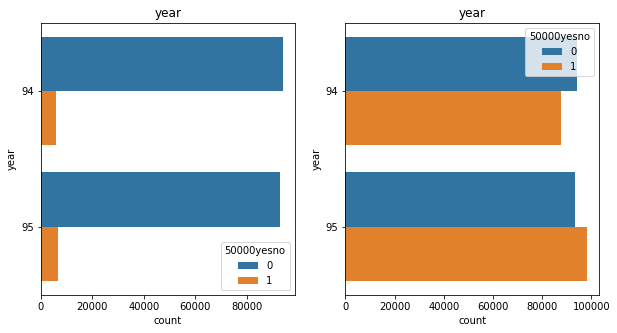

count        199523
unique            2
top        - 50000.
freq         187141
Name: 50000, dtype: object
mode:  0     - 50000.
dtype: object
count        372871
unique            2
top        - 50000.
freq         187141
Name: 50000, dtype: object
mode:  0     - 50000.
dtype: object


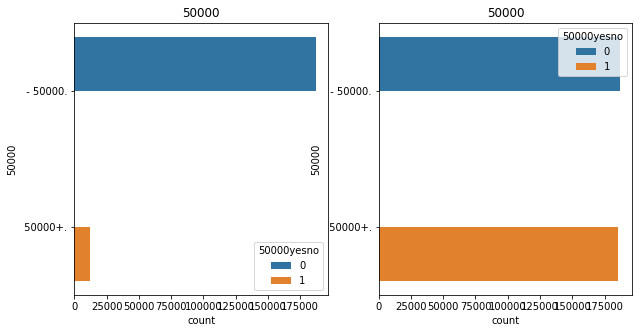

count    199523.000000
mean          0.062058
std           0.241261
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: 50000yesno, dtype: float64
mode:  0    0
dtype: int32
count    372871.000000
mean          0.498108
std           0.499997
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: 50000yesno, dtype: float64
mode:  0    0
dtype: int32


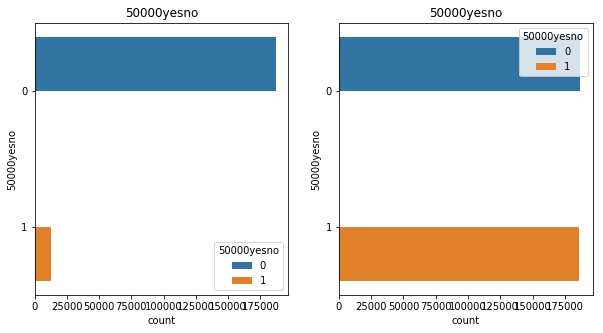

In [14]:
for i in range(0, len(df.columns)):
        categorical_summarized(df, df_final, x=None, y = list(df.columns)[i], hue='50000yesno', palette=c_palette,verbose = False)

### Which attributes are we going to be looking at out of all 41?

Good thing we leveled out the data; as you can see, our before and after graphs look very, very different. If we were to draw conclusions from the first graphs, we'd have vastly different claims.

Next, I want to dive deeper into attributes with skewed responses.

Before we begin, I wanted to address some attributes that referred to very similar ideas. Firstly, if a column seems pretty closely related to another column (for instance, "country of birth father" versus "race"), I went with the attribute that had either more data in universe or was drastic in trends (in this example, I'd choose "race" over "country of birth father", as the latter is a more detailed version, resulting in a lesser identifiable trend). I want to eventually create dummy variables for responses, so I also want to be mindful of not having too many different response options.




In [15]:
## creates my single countplot
def categorical_summarized_single(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    ## determines which axis the variable will be on
    if x == None:
        column_interested = y
    else:
        column_interested = x
    ## creates univariate statistics of aforementioned column using .describe, .mode, and .value_counts()
    series = dataframe[column_interested]
    df2 = dataframe
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(df2.groupby(hue)[column_interested].value_counts())
    ## displays plot
    ax = sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    ax.set_title(column_interested)
    plt.show()

### Exploration of Data

### 1. Age

count    372871.000000
mean         39.967007
std          19.128527
min           0.000000
25%          29.000000
50%          41.000000
75%          52.000000
max          90.000000
Name: age, dtype: float64
mode:  0    46
dtype: int64


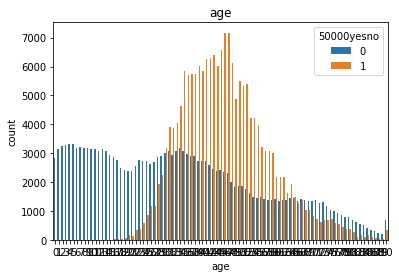

In [16]:
categorical_summarized_single(df_final, x='age', y=None, hue="50000yesno", palette=c_palette, verbose=False)

The above graph shows that there is a definite trend where peple who make 50K tend to be older than those that do not make 50K.. Intuitively, however, as one grows older into later life, this trend drops back down, which makes sense (retirement, people working less, becoming less work efficient).

As age increases, the number of people who make under 50K also decrease, which further supports our claim.

One thing to note as well is that a quarter of our dataset is under the age of 29, which is food for thought, as children don't work full time jobs usually (or I hope they don't, that'd be illegal.)

### 1a. Marital Stat

count                               372871
unique                                   7
top        Married-civilian spouse present
freq                                218622
Name: marital stat, dtype: object
mode:  0     Married-civilian spouse present
dtype: object


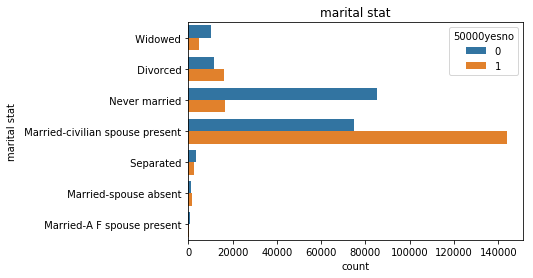

In [17]:
categorical_summarized_single(df_final, x=None, y='marital stat', hue="50000yesno", palette=c_palette, verbose=False)

Once again, we see a huge gap between married and never-married individuals. The two most common responses to this attribute actually share two completely opposite proportions: never married is heavily <50k skewed, whereas married-civilian spouse is the latter. However, keep in mind, as we've already determined that a decent chunk of our data includes children data, this could directly skew our "Never Married' stat.

I'm unsure whether the "Never married" response would be a good indicator, but for married-civilians, I think this further supports our age assertion (as age is probably correlated with marital status, where older individuals are more likely to be married.). 

### 1b. Detailed Household Summary in Household

count           372871
unique               8
top        Householder
freq            210589
Name: detailed household summary in household, dtype: object
mode:  0     Householder
dtype: object


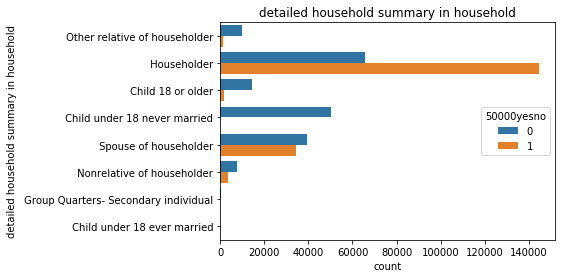

In [18]:
categorical_summarized_single(df_final, x=None, y='detailed household summary in household', hue="50000yesno", palette=c_palette, verbose=False)

Similar to the "Marital Status" statistic, I included this statistic to strengthen my noticing of age being an integral variable. While these two statistics most likely are related, what I found interesting was that the being a householder/spouse of a householder shares two very different trends. We noticed earlier that married-civilians have a higher proportion of individuals that make over 50; however, as seen above, the trend varies dependent on householder.

With the aforementioned attributes, I think we can safely conclude that age is definitely a factor we'll be focusing on to determine whether an individual makes over >50K.

### 2. Education

count                    372871
unique                       17
top        High school graduate
freq                      74713
Name: education, dtype: object
mode:  0     High school graduate
dtype: object


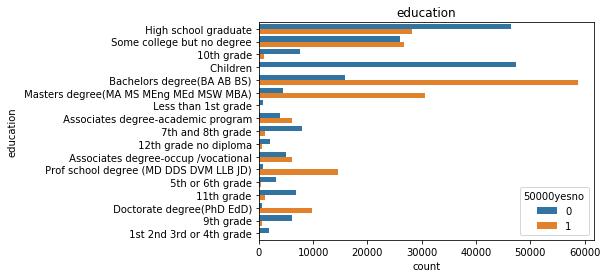

In [19]:
categorical_summarized_single(df_final, x=None, y='education', hue="50000yesno", palette=c_palette, verbose=False)



While this data visualization isn't the prettiest, it's very clear that if someone has even attended in part of higher-level education (either receiving a college degree or attending college), there's a clear difference in proportions. For all education levels under or including HS grad, they're heavily skewed towards "0", whereas every completed college degree is very, very skewed towards 1. I definitely think this is a big finding and will most likely be a forerunner in our model (especially since education levels will most likely correlate to the industry you work in).

### 2a. Class of Worker

count       372871
unique           9
top        Private
freq        174536
Name: class of worker, dtype: object
mode:  0     Private
dtype: object


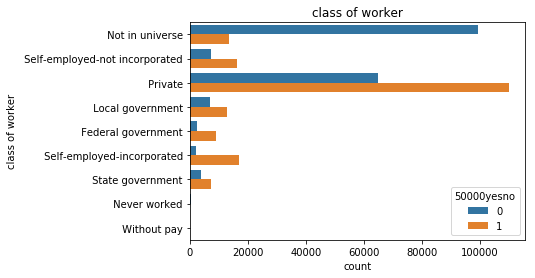

In [20]:
categorical_summarized_single(df_final, x=None, y='class of worker', hue="50000yesno", palette=c_palette, verbose=False)



We can see that a big difference from the "Not in Universe" entry versus the rest; usually when a response includes a worker class, these individuals are more likely to be in the >50K population. Specifically, I think this data definitely proves that the sector you work under directly influences this >50K result. As found in the age, the skewed blue for "Not in Universe" can most likely be attributed to the fact that much of our data includes children (and for many future attributes, "Not in Universe" will most likely be <50K skewed). 

As we also know education directly impacts where you're capable of working at, this supports our claim that education is also a driving factor.

### 2b. Major Occupation Code

count               372871
unique                  15
top        Not in universe
freq                113368
Name: major occupation code, dtype: object
mode:  0     Not in universe
dtype: object


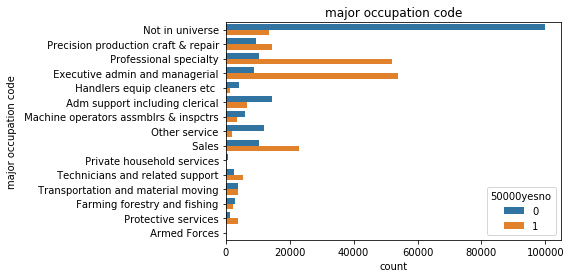

In [21]:
categorical_summarized_single(df_final, x=None, y="major occupation code", hue="50000yesno", palette=c_palette, verbose=False)



The distribution proportions for occupations that are historically less technical or related to labor don't necessarily show any trends, usually hovering at a 1:1 ratio. However, for individuals in occupations that are more office-related or specialized (implying a degree of education), they're more likely to earn more.

This was also seen within industry!

This falls similarly in line with our intuition that work industry/education might play a bigger role than we think

### 3. Num Persons Worked For Employer

count    372871.000000
mean          2.908081
std           2.474244
min           0.000000
25%           0.000000
50%           3.000000
75%           6.000000
max           6.000000
Name: num persons worked for employer, dtype: float64
mode:  0    6
dtype: int64


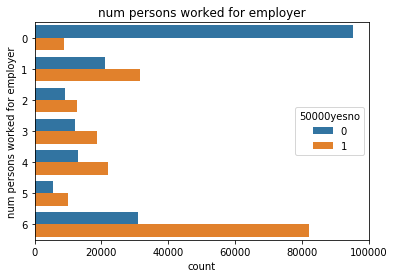

In [22]:
categorical_summarized_single(df_final, x=None, y='num persons worked for employer', hue="50000yesno", palette=c_palette, verbose=False)

Proportion-wise, if there's even a bigger value for "num persons worked", the proportion will increase in favor of the population >50K. I think we can claim that education, along with work situations, will be also driving factors in our model.

### 4. Sex

count     372871
unique         2
top         Male
freq      231605
Name: sex, dtype: object
mode:  0     Male
dtype: object


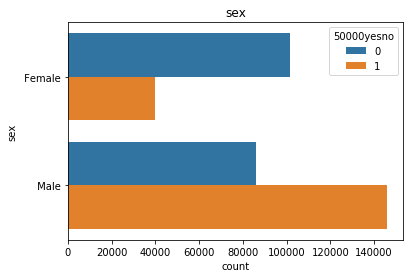

In [23]:
categorical_summarized_single(df_final, x=None, y='sex', hue="50000yesno", palette=c_palette, verbose=False)

Personal identifiers weren't attributes I initially heavily considered, but I think I missed a pretty big glaring factor here. This sex distribution, while unsurprising, was pretty sad to me. The male population on average is more likely to make over 50K in comparison to its female counterpart. 

Something I hadn't considered is the fact that this Sex statistic is binary; it's actually easier to see the trend when one is only comparing one response against the other. I conjecture that this most likely will be actually a more important variable than I initially thought.

Many of the personal identifiers are more difficult to work with given a wide spread, but I chose Sex as an attribute that not only encompasses our data holistically, but is also easy to work with.

## Hypothesis
 After analyzing each attribute graph, based off the trends I've found, I hypothesized that education, occupation/industry, and age were the three most influential factors in determining whether an individual makes over $50K. My intuition seemed correct, and so I stuck with my initial thoughts.

# Model Preparation

As whether or not an individual makes >50K is inherently binary, I thought I'd try to use the logistic regression model.

Notice how earlier, the graphs had a bunch of different responses per attribute.Let's try to prep our data before we actually create our model. As we have a lot of categorical data that we believe would be strong factors in predicting the >50K attribute, let's create dummy variables for them to break down each response one by one, known as one-hot encoding. Our goal here would be to have each column represent a binary "yes or no" to whether that person gave a certain response.

Let's start by breaking down our age category into subgroups (for example, ages 30-35, 40-45, etc.). This is because I noticed earlier that there seemed to be trends over multiple ages.



In [24]:
## rounds down to nearest 5th
import math
def roundup(x):
    return int(math.ceil(x / 10)) * 10
def rounddown(x):
    return int(math.floor(x / 10)) * 10
def myroundfive(x):
    onesdigit = x % 10
    if onesdigit > 4:
        roundedxhigh = roundup(x)
        roundedxlow = roundup(x) -5
    else:
        roundedxlow = rounddown(x) 
        roundedxhigh = rounddown(x) + 5
    return str(str(roundedxlow) + " to " + str(roundedxhigh))
import math

I decided to change the age attribute answers to something a bit more categorical and less divided. Thus, I chose increments of 5, and divided the answers based off a range of ages.

In [25]:
df_final['age']=df_final['age'].apply(lambda x: myroundfive(x))

In [26]:
#list of categorical attributes to create dummy variables out of, one-hot encoding. 
dummylist = ("age", "class of worker", "detailed industry recode", "detailed occupation recode", "education", "enroll in edu inst last wk", "marital stat", "major industry code", "major occupation code", "race", "hispanic origin", "sex", "member of a labor union", "reason for unemployment", "full or part time employment stat", "tax filer stat", "region of previous residence", "state of previous residence", "detailed household and family stat", "detailed household summary in household", "migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "live in this house 1 year ago", "migration prev res in sunbelt", "num persons worked for employer", "family members under 18", "country of birth father", "country of birth mother", "country of birth self", "citizenship", "own business or self employed", "fill inc questionnaire for veteran's admin", "veterans benefits", "year")
#loops through each to create dummy variable, dropping columns where these dummy variables are made
df_dummy=df_final
for i in range(0, len(dummylist)):
    df_dummy = pd.concat([df_dummy, pd.get_dummies(df_final[dummylist[i]], prefix = dummylist[i], drop_first=True)], axis = 1)
    df_dummy.drop(dummylist[i], axis=1, inplace=True)
#our dataset with dummy variables
df_dummy

,wage per hour,capital gains,capital losses,dividends from stocks,weeks worked in year,50000,50000yesno,age_10 to 15,age_15 to 20,age_20 to 25,...,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States,own business or self employed_1,own business or self employed_2,fill inc questionnaire for veteran's admin_ Not in universe,fill inc questionnaire for veteran's admin_ Yes,veterans benefits_1,veterans benefits_2,year_95
0,0,0,0,0,0,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
1,0,0,0,0,52,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,0,0,0,0,0,- 50000.,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,- 50000.,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
5,1200,0,0,0,52,- 50000.,0,0,0,0,...,0,0,1,0,1,1,0,0,1,1
6,0,5178,0,0,52,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
7,0,0,0,0,30,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
8,876,0,0,0,52,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
9,0,0,0,0,52,- 50000.,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


### Dropping Poor Data Quality
I then decided to drop the capital gains/losses and dividends from stocks attributes, as we noticed earlier  that much of the data was either 0 or didn't make much sense in the context of things (such as the $10K/hour point). As we have other economic-related attributes, I don't think this should affect our model too much.

We also checked to drop any highly correlated variables, as we'd want our attributes to be independent of one another.

In [27]:
## drops outlier columns where most of the data is missing/at 0 with no trend.
df_clean = df_dummy
droplist = ('weeks worked in year', 'wage per hour', 'capital gains','capital losses','dividends from stocks', '50000')
for i in range(0, len(droplist)):
    df_clean.drop(droplist[i], axis=1, inplace=True)
### our dataset with dummy variables and dropped outlier columns.
df_clean.shape

(372871, 495)

As you can see below, we had quite a few highly correlatated variables, specifically between occupation and industry code. As aforementioned, we've already known that these variables would be correlated off intuition, as well as migration codes. Cleaning up our data further definitely should help our model accuracy.


In [28]:
# Create correlation matrix
corr_matrix = df_clean.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [29]:
df_clean = df_clean.drop(df_clean[to_drop],axis=1)
### get list of all columns other than the column we're trying to predict.
cols = list(df_clean.columns)
cols.remove('50000yesno')
len(cols)

454

## Feature Selection

454 features (our columns) is too many attributes to choose from; we're going to end up overfitting our data to our training data if we include every attribute (meaning our model would be too catered to this specific dataset).

As a result, I looked for various regularization methods so that we would have a better idea of which of these features were actually more important and correlated with whether an individual makes $50K.


In [31]:
## imports necessary packages
from sklearn.linear_model import ElasticNetCV, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# Using ElasticNetCV to find the optimal hyperparameters
X = df_clean[cols]
y = df_clean['50000yesno']
model_elasticnet = ElasticNetCV(alphas=None, cv=5, eps=0.001, 
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=20000,
       n_alphas=100, n_jobs=-1, normalize=True,precompute='auto', random_state=0)

result_elasticnet = model_elasticnet.fit(X,y);

In [37]:
print('For Elastic Net Model:')
print('Optimal alpha: %.8f'%model_elasticnet.alpha_)
print('Optimal l1_ratio: %.3f'%model_elasticnet.l1_ratio_)
print('Training Score: %.8f'%r2_score(y, model_elasticnet.predict(X)))
preds = model_elasticnet.predict(X)
rmse = np.sqrt(mean_squared_error(y, preds))
print("Test RMSE: %f" % (rmse))

For Elastic Net Model:
Optimal alpha: 0.00000041
Optimal l1_ratio: 1.000
Training Score: 0.57546979
Test RMSE: 0.325778


After finding the proper hyperparameters above, we're finally able to fit this model onto our clean data; when this happens, we'll have a better understanding of attribute strength with the data that comes with the model!

In [38]:
from sklearn.datasets import make_regression
# Fit the optimal ElasticNet model
model = ElasticNet(l1_ratio=model_elasticnet.l1_ratio_, alpha = model_elasticnet.alpha_, max_iter=model_elasticnet.n_iter_, \
                   fit_intercept=True, normalize = True, random_state = 0)
model.fit(X, y)

ElasticNet(alpha=4.0794618415370776e-07, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=727, normalize=True, positive=False,
      precompute=False, random_state=0, selection='cyclic', tol=0.0001,
      warm_start=False)

As you can see below, there are now only 362 "important" features, and we can now organize them!



362 features, reduction of 20.26%


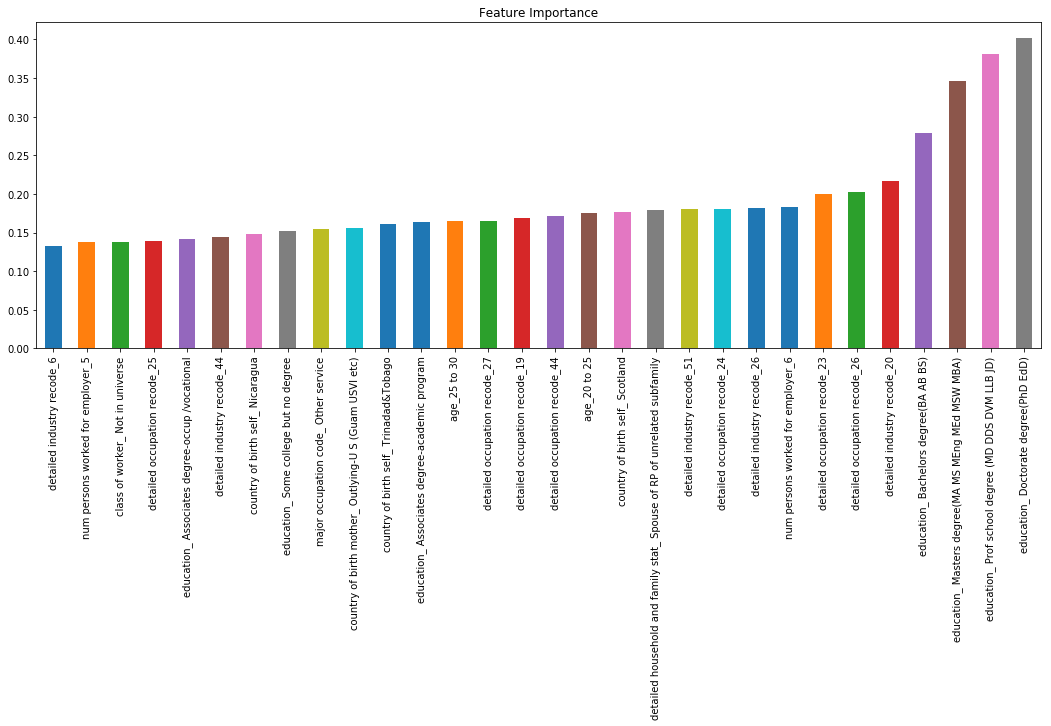

In [39]:
# Plot the feature importance figure
feature_importance = pd.Series(index = X.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

fig, ax = plt.subplots(1,1)

ax = feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6), title = "Feature Importance")
plt.show()

## Observations

Unsurprisingly, education is at the top of the feature importance chart. The most relevant features all deal with having a post-graduate degree; this is seen even further where the attribute of only having some college completed vs. having a full college degree differs by almost 0.1 in feature importance. As education was one of the more skewed trends (where having a college degree drastically increased the proportion of over50K to under50K), this isn't a surprise and supports our claims thus far.

We can also see a reasonably large dropoff from the top 4 values, where when the attributes are no longer university education-related, the importance of the other top 30 attributes seem to be reasonably close together. Perhaps this could imply that other attributes share similar influence against whether an individual earns $50K.


## Training and Testing Our Model

Now that we have a good idea of which features to select, let's test this in the logistic regression model. We'll first look at the broader focus of our feature selection; of these features, what category do they fall under? Are they most pertained to education, occupation, etc.?

In [40]:
### sorted features by importance based off top 30 coefficients.
feature_coef = pd.Series(index = X.columns, data = model.coef_)
feature_sorted = feature_coef[feature_importance.sort_values().tail(410).index.values]
feature_sorted = feature_sorted[-30:]
feature_sorted

detailed industry recode_6                                                -0.132942
num persons worked for employer_5                                          0.137806
class of worker_ Not in universe                                          -0.138162
detailed occupation recode_25                                             -0.138734
education_ Associates degree-occup /vocational                             0.141411
detailed industry recode_44                                               -0.143654
country of birth self_ Nicaragua                                          -0.148710
education_ Some college but no degree                                      0.151479
major occupation code_ Other service                                      -0.154914
country of birth mother_ Outlying-U S (Guam USVI etc)                     -0.155643
country of birth self_ Trinadad&Tobago                                    -0.160856
education_ Associates degree-academic program                              0

A "recode" is a variable calculated by the processing system from a combination of
other items on the file. For example, PRMJOCC1 is the major occupation code for a
household member’s main job; this is not a response to a question but rather a
variable that summarizes (or “groups”) the more finely detailed occupation variable
PEIO1OCD. 


In [41]:
important_features=list(feature_sorted.index)
sorted(important_features)

['age_20 to 25',
 'age_25 to 30',
 'class of worker_ Not in universe',
 'country of birth mother_ Outlying-U S (Guam USVI etc)',
 'country of birth self_ Nicaragua',
 'country of birth self_ Scotland',
 'country of birth self_ Trinadad&Tobago',
 'detailed household and family stat_ Spouse of RP of unrelated subfamily',
 'detailed industry recode_20',
 'detailed industry recode_26',
 'detailed industry recode_44',
 'detailed industry recode_51',
 'detailed industry recode_6',
 'detailed occupation recode_19',
 'detailed occupation recode_23',
 'detailed occupation recode_24',
 'detailed occupation recode_25',
 'detailed occupation recode_26',
 'detailed occupation recode_27',
 'detailed occupation recode_44',
 'education_ Associates degree-academic program',
 'education_ Associates degree-occup /vocational',
 'education_ Bachelors degree(BA AB BS)',
 'education_ Doctorate degree(PhD EdD)',
 'education_ Masters degree(MA MS MEng MEd MSW MBA)',
 'education_ Prof school degree (MD DDS DVM 

Surpirisngly, age groups aren't super relevant, which could potentially lead us to alter our hypothesis that age is a direct factor; something to note is that most people, as they age, do become more educated, and a sa result of that, could earn higher salaries. Older age groups might not necessarily be more likely to make over 50K. Our hypothesis initially that age might be the driving force and more correlated with other factors might not be correct.

However, amongst these other attributes, we see that the most popular broad categories that continue to appear are related to occupation/industry, and education, supporting our hypothesis that these specific broader factors would be a driving force in influencing whether an individual makes 50K.

I think with this, we can defnitely conclude that the education an individual has and the occupation/industry he or she works in are by far the most correlated variables as to whether an individual makes 50K or not, but the age factor is not.


#### Training

I decided to train test split my original training set to see how well it predicted the individuals 50K value from the same dataset for a logistic regression and random forest. I chose logistic regression due to the aforementioned binary nature of the classifier of over/under 50K and due to more personal familiarity. We've oversampled which makes overfitting (our model only doing well on the training set) very possible, so I chose random forest as my second algorithm.

C:\Users\David Sung\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train/Test split results:
LogisticRegression accuracy is 0.816
LogisticRegression log_loss is 0.404
LogisticRegression auc is 0.896


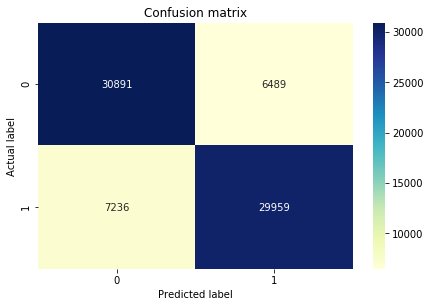


Accuracy: 0.8159570901776735
Precision: 0.8219655399473222
Recall: 0.805457722812206

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     37380
           1       0.82      0.81      0.81     37195

   micro avg       0.82      0.82      0.82     74575
   macro avg       0.82      0.82      0.82     74575
weighted avg       0.82      0.82      0.82     74575



In [43]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
# create X (features) and y (response)
X3 = df_clean[important_features]
y3 = df_clean['50000yesno']

# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_traintest, y_train, y_traintest = train_test_split(X3, y3, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_trainpred = logreg.predict(X_traintest)
y_trainpred_proba = logreg.predict_proba(X_traintest)[:, 1]
[fpr, tpr, thr] = roc_curve(y_traintest, y_trainpred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_traintest, y_trainpred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_traintest, y_trainpred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

# create heatmap
cnf_matrix = metrics.confusion_matrix(y_traintest, y_trainpred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()
print("\nAccuracy:",metrics.accuracy_score(y_traintest, y_trainpred))
print("Precision:",metrics.precision_score(y_traintest, y_trainpred))
print("Recall:",metrics.recall_score(y_traintest, y_trainpred))
print("")
print(classification_report(y_traintest,y_trainpred))

On our training set, it seems like our models, given our selected features, seem to work pretty well! We have reasonably high accuracy, precision, and recall, implying that our model definitely works on the dataset we've fitted it on.

#### Specifically, what these metrics imply is that
i. A high precision means for our training set, we didn't identify that many false positives . You can see that we only predicted 6500 "false positives" (where we identified individuals that didn't make 50K as those who did).


ii. A high recall means that on our training set, we returned a high percentage of the relevant results; in this case, 
the population actually made over 50K was well-identified through our predictions. We didn't have many false negatives, meaning people we identified as under when they were actually over.
    

In [46]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_train_features = X_train
rf_train_labels = y_train
rf_test_features = X_traintest
rf_test_labels = y_traintest
# Train the model on training data
rf.fit(rf_train_features, rf_train_labels);
# Use the forest's predict method on the training data
rf_predictions = rf.predict(rf_test_features)
# Calculate the absolute errors
errors = abs(rf_predictions - rf_test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print(accuracy_score(rf_test_labels, rf_predictions.round()))
print(classification_report(rf_test_labels,rf_predictions.round()))  

Mean Absolute Error: 0.25 degrees.
0.8219778746228629
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     37380
           1       0.82      0.83      0.82     37195

   micro avg       0.82      0.82      0.82     74575
   macro avg       0.82      0.82      0.82     74575
weighted avg       0.82      0.82      0.82     74575



##### Next, I had to transform my test.csv in the same way I did my training set. I decided to use logistic regression as the number seemed pretty close to one another on the training set, and that I'd be more comfortable analyzing a logreg model on the training set. I personally haven't worked with that many random forests, so finding parameters for me to optimally use the algorithm would definitely be harder for me. Our models shared similar findings.

In [61]:
## loads test cs
col_names = ["age", "class of worker", "detailed industry recode", "detailed occupation recode", "education", "wage per hour", "enroll in edu inst last wk", "marital stat", "major industry code", "major occupation code", "race", "hispanic origin", "sex", "member of a labor union", "reason for unemployment", "full or part time employment stat", "capital gains", "capital losses", "dividends from stocks", "tax filer stat", "region of previous residence", "state of previous residence", "detailed household and family stat", "detailed household summary in household", "instance weight", "migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "live in this house 1 year ago", "migration prev res in sunbelt", "num persons worked for employer", "family members under 18", "country of birth father", "country of birth mother", "country of birth self", "citizenship", "own business or self employed", "fill inc questionnaire for veteran's admin", "veterans benefits", "weeks worked in year", "year", "50000"]
df_test = pd.read_csv("/Users/David Sung/Desktop/us_census_fuLl/census_income_test.csv", names = col_names, header= None)
df_test = df_test.drop(['instance weight'], axis=1)
df_test['50000yesno'] = np.where(df_test['50000'] == ' 50000+.', int(1), int(0))
#changes age into a grouped age statistic
df_test['age']=df_test['age'].apply(lambda x: myroundfive(x))
#list of attributes to create dummy variables
dummylist = ("age","class of worker", "detailed industry recode", "detailed occupation recode", "education", "enroll in edu inst last wk", "marital stat", "major industry code", "major occupation code", "race", "hispanic origin", "sex", "member of a labor union", "reason for unemployment", "full or part time employment stat", "tax filer stat", "region of previous residence", "state of previous residence", "detailed household and family stat", "detailed household summary in household", "migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "live in this house 1 year ago", "migration prev res in sunbelt", "num persons worked for employer", "family members under 18", "country of birth father", "country of birth mother", "country of birth self", "citizenship", "own business or self employed", "fill inc questionnaire for veteran's admin", "veterans benefits", "year")
#loops through each to create dummy variable, dropping columns where these dummy variables are made
df_testdummy=df_test
for i in range(0, len(dummylist)):
    df_testdummy = pd.concat([df_testdummy, pd.get_dummies(df_test[dummylist[i]], prefix = dummylist[i], drop_first=True)], axis = 1)
    df_testdummy.drop(dummylist[i], axis=1, inplace=True)
for i in range(0, len(droplist)):
    df_testdummy.drop(droplist[i], axis=1, inplace=True)
df_testdummy.head()


,50000yesno,age_10 to 15,age_15 to 20,age_20 to 25,age_25 to 30,age_30 to 35,age_35 to 40,age_40 to 45,age_45 to 50,age_5 to 10,...,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States,own business or self employed_1,own business or self employed_2,fill inc questionnaire for veteran's admin_ Not in universe,fill inc questionnaire for veteran's admin_ Yes,veterans benefits_1,veterans benefits_2,year_95
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,1


Above is our ready to use test set for our model.

## Running our Model on the Test Set

C:\Users\David Sung\Documents\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression accuracy is 0.824
LogisticRegression log_loss is 0.413
LogisticRegression auc is 0.897

Accuracy: 0.8243419338024498
Precision: 0.23377477223631069
Recall: 0.8047203362431297

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     93576
           1       0.23      0.80      0.36      6186

   micro avg       0.82      0.82      0.82     99762
   macro avg       0.61      0.82      0.63     99762
weighted avg       0.94      0.82      0.86     99762



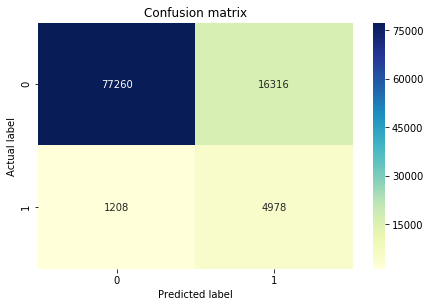

In [62]:
X3 = df_clean[important_features]
y3 = df_clean['50000yesno']
X_test = df_testdummy[important_features]
y_test = df_testdummy['50000yesno']

# check classification scores of logistic regression
logreg.fit(X3, y3)
y_test_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_test_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show
print("\nAccuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("Precision:",metrics.precision_score(y_test, y_test_pred))
print("Recall:",metrics.recall_score(y_test, y_test_pred))
print("")
print(classification_report(y_test, y_test_pred))

### Model Discussion 

Our hypothesis that as one grows older/more educated, the more likely he makes more than 50K might not be necessarily true. While definitely correlated, it's hard to say given our test results, that these factors are a good indication of whether an individual actually DOES make 50K. We can see that easily through the 16316 (80% of what the model deemed to be over 50K was in fact actually under 50K). 

Looks like we're not in luck. While our recall value stayed practically the same (we're still identifying well the false negatives (the individuasl we claim over when they're actually under) and those that we've predicted to be over that are actually over), notice how our precision value has drastically decreased.

This implies that our model actually is identifying too many positives. The best example I can give here would be that our model might hold certain attributes to too high a regard. We might not be wrong very often when we're identifying people that do not make 50K, but when we're identifying people that do, our model falls flat.

As you can see, our model rarely identifies an individual as under when he actually does make over 50K, but falls short when overly identifying too many individuals as over 50K, when they only make under 50K.

Our accuracy doesn't fall here due to the fact that most of the data is still going to be skewed towards people that make less than 50K; while it looks like we're pretty accurate, we tend to guess too many "yes" to whether an individual makes 50K.

### Conclusion

To sum it up, we initially believed that age, education, and occupation/industry information would be the driving factors behind determining whether an individual makes over or under 50K. Concluded by our feature selection, we saw that indeed, the most important factor seemed to be specifically having a college degree; our most important features actually strictly dealt with education. 

However, our model ultimately was inefficient due to overfitting and bias. I oversampled my data to have more even distributions of data, but I do think this played a pretty big factor in our model having a high false positive rate on the test set. Looking back, it would've been beneficial to over sample after I created my dummy variables post cross validation and not just duplicate my positives. Post project, I believe undersampling might have been a better option, as I'm not recreating data, and can randomly sample for my vast negatives.

Another option to address this oversampling would be to further identify variables that had a wide range of responses: my first thoughts would be to readdress these industry/occupation recodes. As these recodes summarize groups, it might be best to have more information about what these recodes represent.
